/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:2272: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


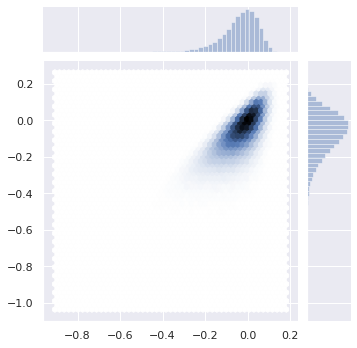

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
dataset = np.zeros(shape=(300000,2))
for j in range(0,300000):
    x1, x2 = np.random.exponential(size=2)
    x2 *= x1
    dataset[j][0] = np.log(x1) / 15
    dataset[j][1] = np.log(x2) / 15
sns.jointplot(dataset[:,0],dataset[:,1],kind='hex',size=5)

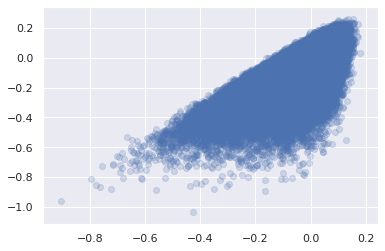

In [2]:
plt.scatter(dataset[:,0],dataset[:,1],alpha=0.2)

In [3]:
dataset = np.array(dataset)
dataset=dataset.reshape(-1,1,2)
dataset[0].shape

(1, 2)

In [4]:
dataset.shape

(300000, 1, 2)

# Smaller learning rate with normal network

Using TensorFlow backend.


Epoch: 0


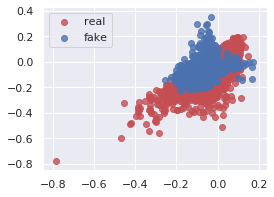

Epoch: 500


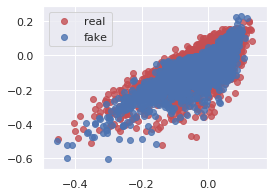

Epoch: 1000


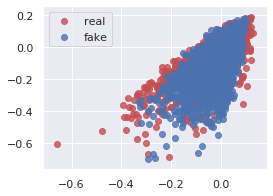

Epoch: 1500


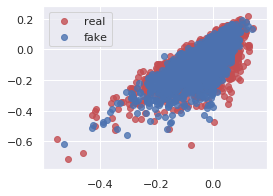

Epoch: 2000


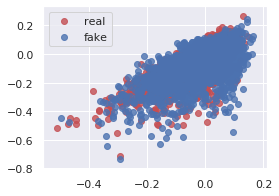

Epoch: 2500


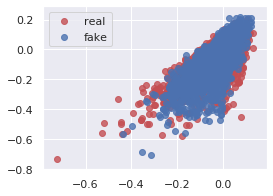

Epoch: 3000


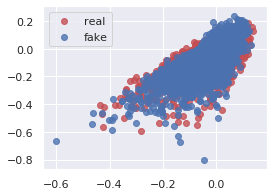

Epoch: 3500


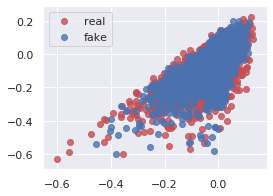

Epoch: 4000


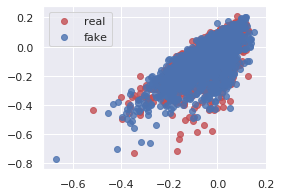

Epoch: 4500


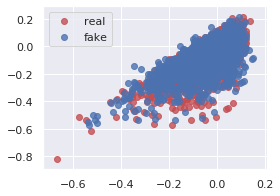

Epoch: 5000


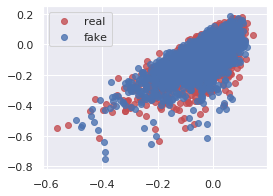

Epoch: 5500


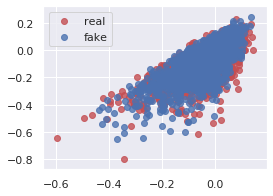

Epoch: 6000


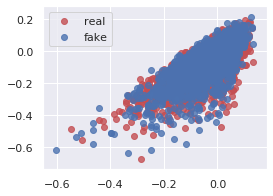

Epoch: 6500


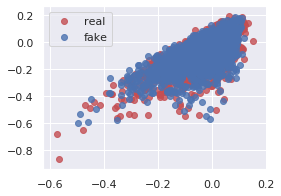

Epoch: 7000


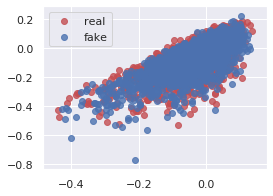

Epoch: 7500


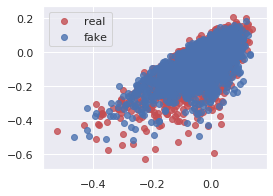

Epoch: 8000


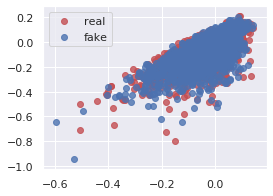

Epoch: 8500


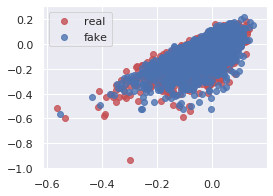

Epoch: 9000


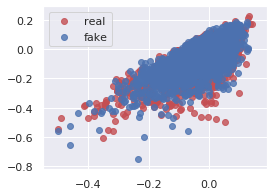

Epoch: 9500


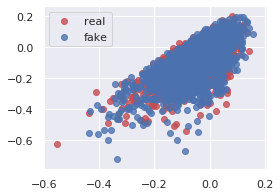

Epoch: 10000


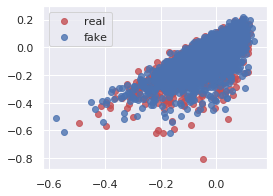

Epoch: 10500


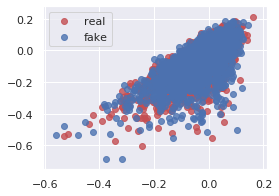

Epoch: 11000


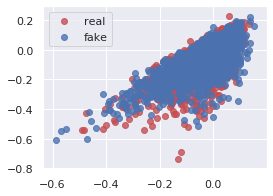

Epoch: 11500


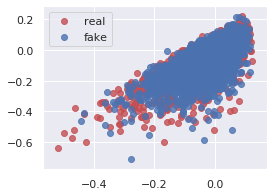

Epoch: 12000


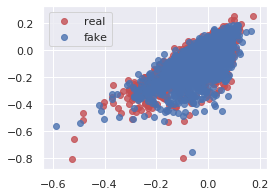

Epoch: 12500


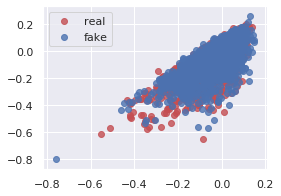

Epoch: 13000


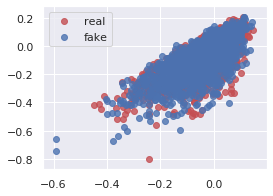

Epoch: 13500


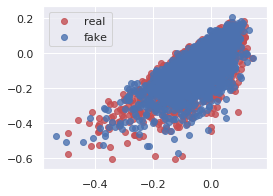

Epoch: 14000


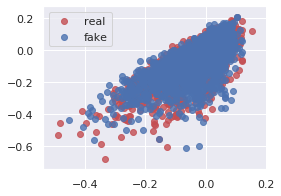

Epoch: 14500


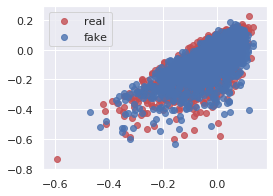

Epoch: 15000


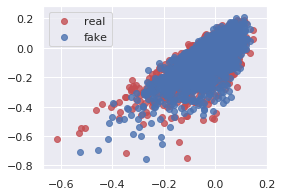

Epoch: 15500


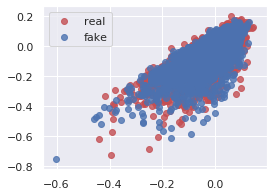

Epoch: 16000


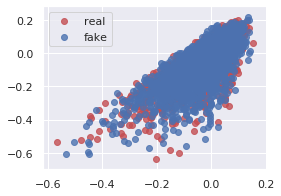

Epoch: 16500


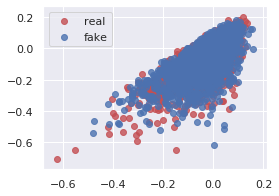

Epoch: 17000


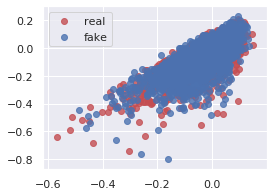

Epoch: 17500


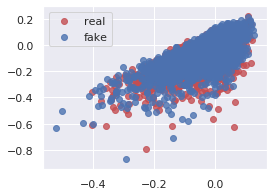

Epoch: 18000


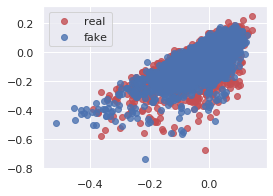

Epoch: 18500


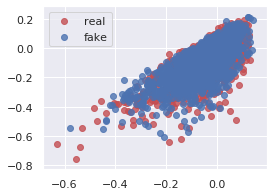

Epoch: 19000


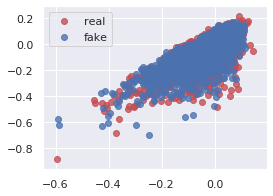

Epoch: 19500


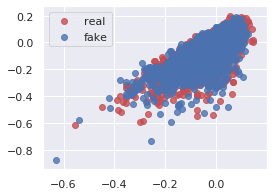

Epoch: 20000


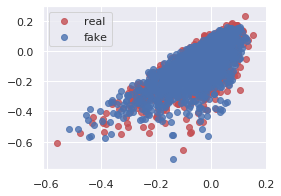

Epoch: 20500


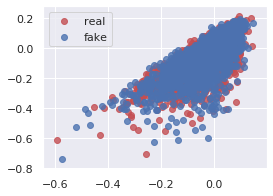

In [5]:
import seaborn as sns, numpy as np
from scipy.stats import entropy
from numpy import hstack
from numpy import zeros
from numpy import ones
from numpy.random import rand,randint
from numpy.random import randn, exponential
from keras.models import Sequential
from keras.layers import Dense, LeakyReLU, BatchNormalization, Reshape, Flatten
from matplotlib import pyplot
from keras import optimizers
import tensorflow as tf
from numpy.random import random, choice
m1=[[],[]]
m2=[[],[]]
real_shuffle_acc=[[],[]]
fake_shuffle_acc=[[],[]]
g_loss=[[],[]]
d_loss=[[],[]]

import warnings
warnings.filterwarnings('ignore')

# define the standalone discriminator model
def define_discriminator():
    model = Sequential()
    model.add(Dense(100, input_shape=(1,2)))
    model.add(LeakyReLU(alpha = 0.2))
    model.add(Dense(500))
    model.add(LeakyReLU(alpha = 0.2))
    model.add(Dense(500))
    model.add(LeakyReLU(alpha = 0.2))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = optimizers.RMSprop(lr=0.0002, decay=1e-10)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

# define the standalone generator model
def define_generator(latent_dim):
    model = Sequential()
    model.add(Dense(100, input_shape=[latent_dim]))
    model.add(LeakyReLU(alpha = 0.2))
    model.add(Dense(100))
    model.add(LeakyReLU(alpha = 0.2))
    model.add(Dense(300))
    model.add(LeakyReLU(alpha = 0.2))
    model.add(Dense(2))
    model.add(LeakyReLU(alpha = 0.2))
    model.add(Reshape((1,2)))
    return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
    # make weights in the discriminator not trainable
    discriminator.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(generator)
    # add the discriminator
    model.add(discriminator)
    # compile model
    opt = optimizers.Adam(lr=0.0001, decay=1e-10)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

# generate n real samples with class labels
def generate_real_samples(n_samples):
    dataset = np.zeros(shape=(n_samples,2))
    for j in range(n_samples):
        x1, x2 = np.random.exponential(size=2)
        x2 *= x1
        dataset[j][0] = np.log(x1) / 15
        dataset[j][1] = np.log(x2) / 15
    
    dataset = dataset.reshape(-1,1,2)
    y=ones((n_samples,1))
    return dataset, y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n):
    # generate points in the latent space
    x_input = randn(latent_dim * n)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n, latent_dim)
    return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n)
    # predict outputs
    X = generator.predict(x_input)
    # create class labels
    y = zeros((n, 1))
    return X, y

# evaluate the discriminator and plot real and fake points
def summarize_performance(epoch, generator, discriminator, latent_dim, n=2000):
    # prepare real samples
    x_real, y_real = generate_real_samples(n)
    x_fake, y_fake = generate_fake_samples(generator, latent_dim, n)
    _, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
    _, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
    
    x_fake = x_fake.reshape(n,2)
    x_real = x_real.reshape(n,2)
    plt.figure(figsize=(4,3))
    plt.scatter(x_real[:,0],x_real[:,1],alpha=0.8,color='r', label='real')
    plt.scatter(x_fake[:,0],x_fake[:,1],alpha=0.8,color='b', label='fake')  
    print("Epoch:",epoch)
    plt.legend()
    plt.show()

def smooth_positive_labels(y):
    return y - 0.3 + (random(y.shape) * 0.5)
def smooth_negative_labels(y):
    return y + 0.3 + (random(y.shape) * 0.3)


# train the generator and discriminator
def train(g_model, d_model, gan_model, latent_dim, n_epochs=21000, n_batch=256, n_eval=500):
    # determine half the size of one batch, for updating the discriminator
    bat_per_eop = int(5000 / n_batch)
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        for j in range(bat_per_eop):
            # prepare real samples
            x_real, y_real = generate_real_samples(half_batch)
            # prepare fake examples
            x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            y_real = smooth_positive_labels(y_real)
            y_fake = smooth_negative_labels(y_fake)
            # update discriminator
            loss_1=d_model.train_on_batch(x_real, y_real)
            loss_2=d_model.train_on_batch(x_fake, y_fake)
            # prepare points in latent space as input for the generator
            x_gan = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = ones((n_batch, 1))
            y_gan = smooth_positive_labels(y_gan)
            # update the generator via the discriminator's error
            loss_3=gan_model.train_on_batch(x_gan, y_gan)
            d_loss.append(loss_1[0]+loss_2[0])
            g_loss.append(loss_3)
            # evaluate the model every n_eval epochs
        x_fake = x_fake.reshape(-1,2)
        x_real = x_real.reshape(-1,2)
        m1[0].append(i)
        m1[1].append(entropy(x_fake[:,0],x_real[:,0]))
        m2[0].append(i)
        m2[1].append(entropy(x_fake[:,1],x_real[:,1])) 
        if (i) % n_eval == 0:
            summarize_performance(i, g_model, d_model, latent_dim)
            d_loss[1].append(loss_1[0]+loss_2[0])
            g_loss[1].append(loss_3)
            d_loss[0].append(i)
            g_loss[0].append(i)

with tf.device('/device:GPU:3'):

    # size of the latent space
    latent_dim = 30
    # create the discriminator
    discriminator = define_discriminator()
    # create the generator
    generator = define_generator(latent_dim)
    # create the gan
    gan_model = define_gan(generator, discriminator)
    # train model
    train(generator, discriminator, gan_model, latent_dim)

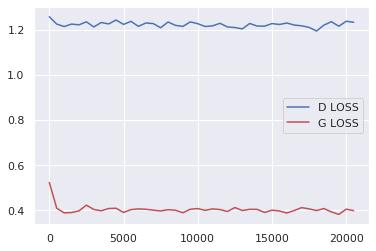

In [6]:
line_down, =pyplot.plot(g_loss[0],g_loss[1],color='r',label="G LOSS")
line_up, =pyplot.plot(d_loss[0],d_loss[1],color='b',label="D LOSS")
pyplot.legend(handles=[line_up, line_down])

# WGAN

Using TensorFlow backend.


total steps 20000
Epoch: 0


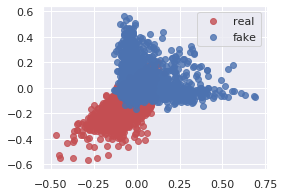

Epoch: 1000


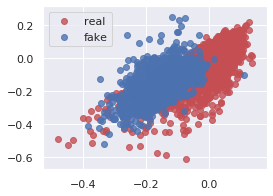

Epoch: 2000


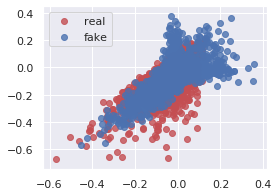

Epoch: 3000


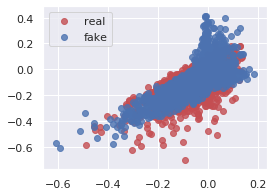

Epoch: 4000


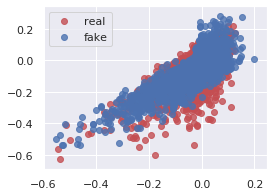

Epoch: 5000


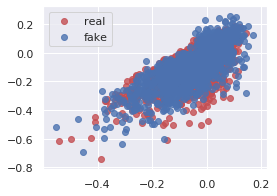

Epoch: 6000


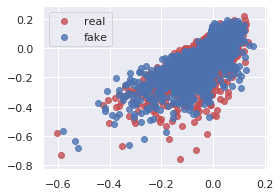

Epoch: 7000


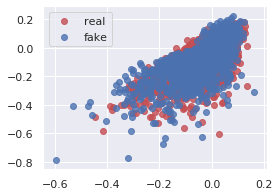

Epoch: 8000


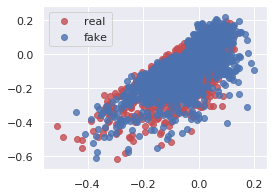

Epoch: 9000


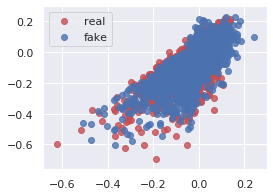

Epoch: 10000


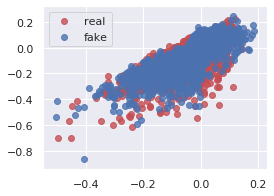

Epoch: 11000


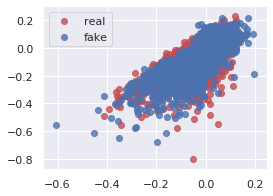

Epoch: 12000


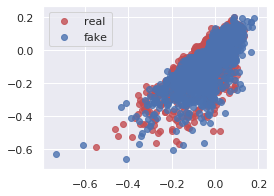

Epoch: 13000


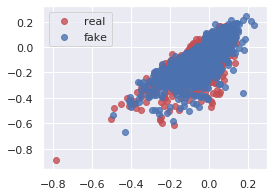

Epoch: 14000


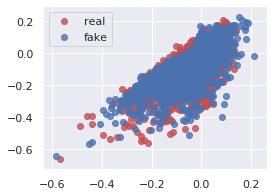

Epoch: 15000


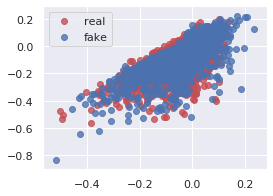

Epoch: 16000


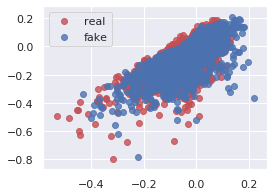

Epoch: 17000


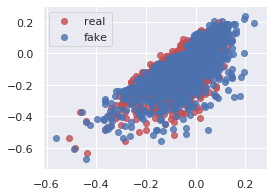

Epoch: 18000


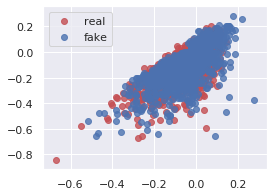

Epoch: 19000


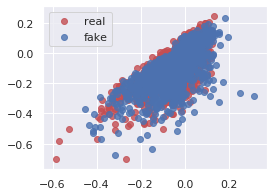

In [1]:
# example of a wgan for generating handwritten digits
import tensorflow as tf
import seaborn as sns
import numpy as np
from numpy import expand_dims
from numpy import mean
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.datasets.mnist import load_data
from keras import backend
from keras import optimizers
from keras.optimizers import RMSprop
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import BatchNormalization
from keras.initializers import RandomNormal
from keras.constraints import Constraint
from matplotlib import pyplot
import matplotlib.pyplot as plt
sns.set()
g_loss_li=list()
d_loss_real=list()
d_loss_fake=list()
import warnings
warnings.filterwarnings('ignore')

# clip model weights to a given hypercube
class ClipConstraint(Constraint):
    # set clip value when initialized
    def __init__(self, clip_value):
        self.clip_value = clip_value

    # clip model weights to hypercube
    def __call__(self, weights):
        return backend.clip(weights, -self.clip_value, self.clip_value)

    # get the config
    def get_config(self):
        return {'clip_value': self.clip_value}

# calculate wasserstein loss
def wasserstein_loss(y_true, y_pred):
    return backend.mean(y_true * y_pred)

# define the standalone critic model
def define_critic():
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # weight constraint
    const = ClipConstraint(0.01)
    model = Sequential()
    model.add(Dense(100, input_shape=(1,2), kernel_constraint=const))
    model.add(LeakyReLU(alpha = 0.2))
    model.add(Dense(500, kernel_constraint=const))
    model.add(LeakyReLU(alpha = 0.2))
    model.add(Dense(500, kernel_constraint=const))
    model.add(LeakyReLU(alpha = 0.2))
    model.add(Flatten())
    model.add(Dense(1))
    # compile model
    opt = optimizers.RMSprop(lr=0.00002, decay=1e-10)
    model.compile(loss=wasserstein_loss, optimizer=opt)
    return model

# define the standalone generator model
def define_generator(latent_dim):
    model = Sequential()
    model.add(Dense(100, input_shape=[latent_dim]))
    model.add(LeakyReLU(alpha = 0.2))
    model.add(Dense(100))
    model.add(LeakyReLU(alpha = 0.2))
    model.add(Dense(300))
    model.add(LeakyReLU(alpha = 0.2))
    model.add(Dense(2))
    model.add(LeakyReLU(alpha = 0.2))
    model.add(Reshape((1,2)))
    return model

# define the combined generator and critic model, for updating the generator
def define_gan(generator, critic):
    # make weights in the critic not trainable
    critic.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(generator)
    # add the critic
    model.add(critic)
    # compile model
    opt = optimizers.RMSprop(lr=0.00001, decay=1e-10)
    model.compile(loss=wasserstein_loss, optimizer=opt)
    return model

# select real samples
def generate_real_samples(n_samples):
    dataset = np.zeros(shape=(n_samples,2))
    for j in range(n_samples):
        x1, x2 = np.random.exponential(size=2)
        x2 *= x1
        dataset[j][0] = np.log(x1) / 15
        dataset[j][1] = np.log(x2) / 15
    
    dataset = dataset.reshape(-1,1,2)
    y = -ones((n_samples,1))
    return dataset, y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = generator.predict(x_input)
    # create class labels with 1.0 for 'fake'
    y = ones((n_samples, 1))
    return X, y

# generate samples and save as a plot and save the model
def summarize_performance(epoch, generator, discriminator, latent_dim, n=2000):
    # prepare real samples
    x_real, y_real = generate_real_samples(n)
    x_fake, y_fake = generate_fake_samples(generator, latent_dim, n)
    
    x_fake = x_fake.reshape(n,2)
    x_real = x_real.reshape(n,2)
    plt.figure(figsize=(4,3))
    plt.scatter(x_real[:,0],x_real[:,1],alpha=0.8,color='r', label='real')
    plt.scatter(x_fake[:,0],x_fake[:,1],alpha=0.8,color='b', label='fake')   
    print("Epoch:",epoch)
    plt.legend()
    plt.show()
    
def plot_history(d1_hist, d2_hist, g_hist):
    # plot history
    pyplot.plot(d1_hist, label='crit_real')
    pyplot.plot(d2_hist, label='crit_fake')
    pyplot.plot(g_hist, label='gen')
    pyplot.legend()
    pyplot.savefig('plot_line_plot_loss.png')
    pyplot.close()

# train the generator and critic
def train(g_model, c_model, gan_model, latent_dim, n_epochs=2000, n_batch=1000, n_critic=5, n_eval=1000):
    # calculate the number of batches per training epoch
    bat_per_epo = int(10000 / n_batch)
    # calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs
    # calculate the size of half a batch of samples
    half_batch = int(n_batch / 2)
    # lists for keeping track of loss
    c1_hist, c2_hist, g_hist = list(), list(), list()
    # manually enumerate epochs
    print("total steps",n_steps)
    for i in range(n_steps):
        # update the critic more than the generator
        c1_tmp, c2_tmp = list(), list()
        for _ in range(n_critic):
            # get randomly selected 'real' samples
            X_real, y_real = generate_real_samples(half_batch)
            # update critic model weights
            c_loss1 = c_model.train_on_batch(X_real, y_real)
            c1_tmp.append(c_loss1)
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update critic model weights
            c_loss2 = c_model.train_on_batch(X_fake, y_fake)
            c2_tmp.append(c_loss2)
        # store critic loss
        d_loss_real.append(mean(c1_tmp))
        d_loss_fake.append(mean(c2_tmp))
        # prepare points in latent space as input for the generator
        X_gan = generate_latent_points(latent_dim, n_batch)
        # create inverted labels for the fake samples
        y_gan = -ones((n_batch, 1))
        # update the generator via the critic's error
        g_loss = gan_model.train_on_batch(X_gan, y_gan)
        g_loss_li.append(g_loss)
        # evaluate the model performance every 'epoch'
        if (i) % n_eval == 0:
            summarize_performance(i, generator, critic, latent_dim)
            
with tf.device('/device:GPU:3'):
    # size of the latent space
    latent_dim = 30
    # create the critic
    critic = define_critic()
    # create the generator
    generator = define_generator(latent_dim)
    # create the gan
    gan_model = define_gan(generator, critic)
    # train model
    train(generator, critic, gan_model, latent_dim)
    

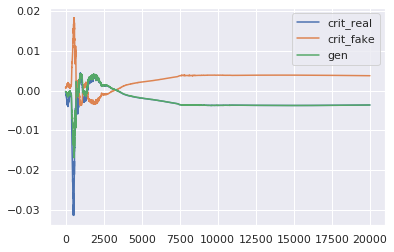

In [2]:
def plot_history(d1_hist, d2_hist, g_hist):
    # plot history
    pyplot.plot(d1_hist, label='crit_real')
    pyplot.plot(d2_hist, label='crit_fake')
    pyplot.plot(g_hist, label='gen')
    pyplot.legend()
    pyplot.show()

plot_history(d_loss_real, d_loss_fake,g_loss_li)